[*********************100%%**********************]  1 of 1 completed
Current price is: $424.66
The drift coefficient is: -0.0013290792953031866 
The volatility is: 0.007350542064717206


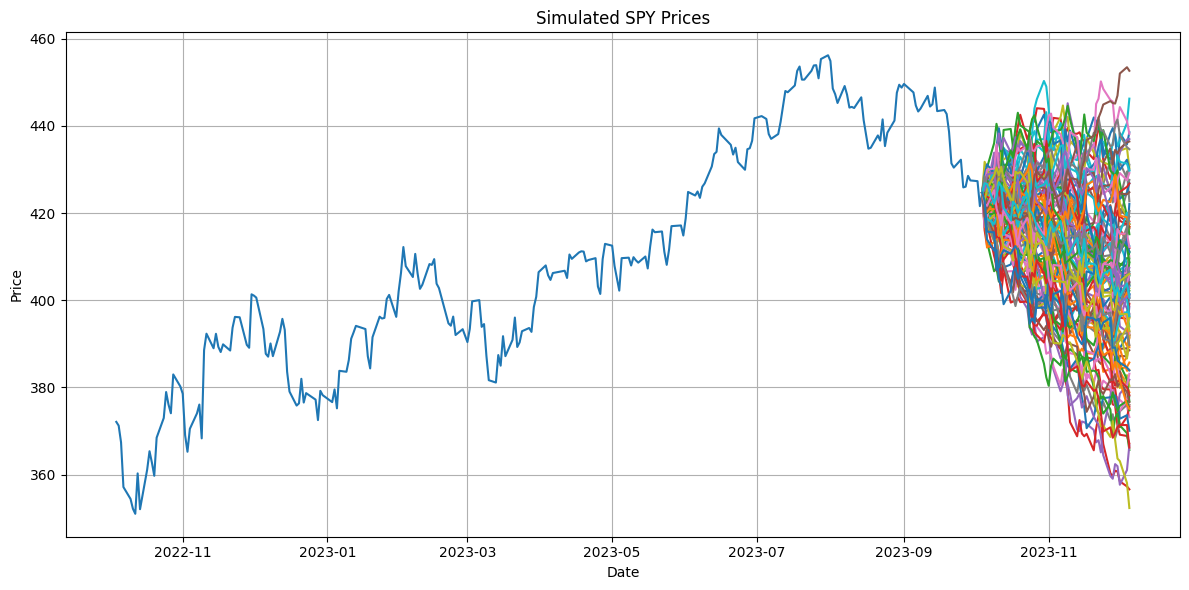

In [158]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

STOCK_SYMBOL = "SPY" # Define the stock symbol
NUM_ITERATIONS = 100  # Number of GBM simulations to perform
TIME_HORIZON = 44 # Define the time horizon for the simulation (in trading days)
if NUM_ITERATIONS > 15:
    LEGEND_STATE = False
else:
    LEGEND_STATE = True

# Fetch historical stock data
end_date = pd.Timestamp.today()
stock_data = yf.download(STOCK_SYMBOL, end=end_date)
# Extract the most recent closing price
current_price = stock_data['Adj Close'][-1]
print(f"Current price is: ${np.round(current_price, decimals=2)}")
# Calculate daily returns (log returns)
log_returns = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1)).dropna()

# Calculate the mean and standard deviation of daily log returns
mean_return = log_returns[-50:].mean() #-0.0005041111558246226 #
std_deviation = log_returns[-50:].std() #0.004511456656686498 #
print(f"The drift coefficient is: {mean_return} \nThe volatility is: {std_deviation}")

# Initialize arrays to store simulated prices
simulated_prices = np.zeros((NUM_ITERATIONS, TIME_HORIZON + 1))
# Perform GBM simulations
for i in range(NUM_ITERATIONS):
    # Generate random shocks (standard normal) for the time horizon
    random_shocks = np.random.normal(0, 1, TIME_HORIZON)
    # Calculate the simulated price path
    price_path = np.zeros(TIME_HORIZON + 1)
    price_path[0] = current_price
    for j in range(1, TIME_HORIZON + 1):
        price_path[j] = price_path[j - 1] * np.exp((mean_return - (std_deviation ** 2) / 2) + std_deviation * random_shocks[j - 1])
    simulated_prices[i, :] = price_path
simulated_prices_df = pd.DataFrame(simulated_prices).T
simulated_prices_df = simulated_prices_df.set_index(pd.date_range(start=pd.to_datetime(stock_data.index[-1]), periods = TIME_HORIZON+1, freq = 'b'))
#simulated_prices_df = simulated_prices_df[simulated_prices_df.index.dayofweek < 5]

# Plot the previous month's daily stock prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[-252:], stock_data['Adj Close'][-252:])
plt.plot(simulated_prices_df)
plt.title(f"Simulated {STOCK_SYMBOL} Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
if LEGEND_STATE == True:
    plt.legend(simulated_prices_df.columns)
plt.tight_layout()
plt.show()

In [159]:

options_data_expiry_time = end_date + pd.Timedelta(TIME_HORIZON, "d")
options_data_expiry_time = options_data_expiry_time.strftime('%Y-%m-%d')

STRIKE_PRICE = 424
CALL_OR_PUT = "call"

options_data = yf.Ticker(STOCK_SYMBOL).option_chain(options_data_expiry_time)
calls = options_data.calls
calls[calls['strike'] == STRIKE_PRICE]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
64,SPY231117C00424000,2023-10-04 20:13:05+00:00,424.0,11.7,11.61,11.68,1.07,10.065848,919.0,8199,0.193062,True,REGULAR,USD


In [160]:
import numpy as np
from scipy.stats import norm #importing the normal distribution function only 

#call price function, sigma=volatility(σ)
def BSM_call_price(S, K , T , r , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T)) 
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2) 

#put price function, sigma = volatility(σ)
def BSM_put_price(S, K , T , r , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)


Showing results for 62 day(s) to expire
               0      1      2      3      4      5      6      7      8   \
2023-10-04  23.53  23.53  23.53  23.53  23.53  23.53  23.53  23.53  23.53   
2023-10-05  21.30  18.80  19.62  20.98  20.58  23.73  24.97  21.24  27.00   
2023-10-06  18.17  14.56  17.50  20.80  20.40  24.80  20.11  17.43  24.40   
2023-10-09  16.05   9.71  11.70  17.87  18.93  20.11  21.86  13.80  21.93   
2023-10-10  18.90   9.82  10.27  20.01  19.22  16.28  20.10  15.60  20.45   
2023-10-11  15.00   8.03   8.89  15.67  20.38  18.60  21.97  13.21  17.84   
2023-10-12  15.81   8.37   6.61  14.48  22.43  19.42  20.25  12.97  18.60   
2023-10-13  13.06  10.84   8.73  13.82  25.28  16.77  21.78  10.61  20.94   
2023-10-16  14.87  10.26   6.86  15.79  21.59  16.20  26.26  12.07  15.89   
2023-10-17  13.02   9.64   7.41  15.55  18.78  12.40  21.09  11.36  14.85   
2023-10-18  12.60   8.07   8.48  16.48  17.28   9.23  19.65  11.55  15.63   
2023-10-19  12.55   6.85   9.14  13.

<Axes: >

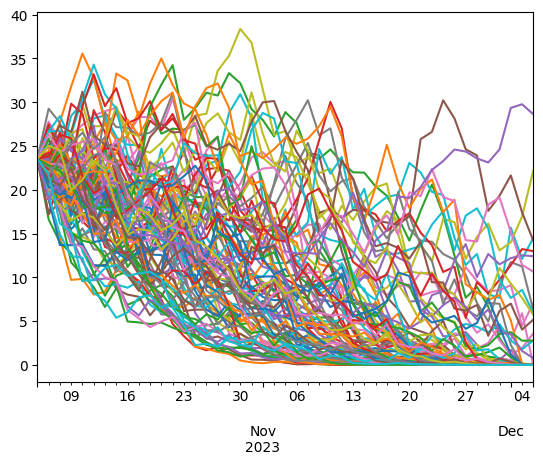

In [161]:
import warnings

option_price_index = pd.date_range(start = simulated_prices_df.index[0], end = simulated_prices_df.index[-1], freq = 'b')
option_price_df = pd.DataFrame(index=option_price_index )
annualized_vol = std_deviation * np.sqrt(252)

for sim_index in simulated_prices_df:
    trajectory = simulated_prices_df[sim_index]
    expiry_delta = simulated_prices_df[0].index[-1] - simulated_prices_df[0].index
    expiry_time_annualized = expiry_delta.days / 252
    if CALL_OR_PUT is "call":
        option_price_trajectory = BSM_call_price(trajectory, STRIKE_PRICE, expiry_time_annualized, 0.2, annualized_vol)
    elif CALL_OR_PUT is "put":
        option_price_trajectory = BSM_put_price(trajectory, STRIKE_PRICE, expiry_time_annualized, 0.2, annualized_vol)
    option_price_df[sim_index] = np.round(option_price_trajectory, decimals = 2)
print("Showing results for {} day(s) to expire".format(expiry_delta.days[0]))
print(option_price_df)
warnings.simplefilter('ignore')
option_price_df.plot(legend = LEGEND_STATE)

0     23.53
1     23.53
2     23.53
3     23.53
4     23.53
      ...  
95    23.53
96    23.53
97    23.53
98    23.53
99    23.53
Name: 2023-10-04 00:00:00, Length: 100, dtype: float64


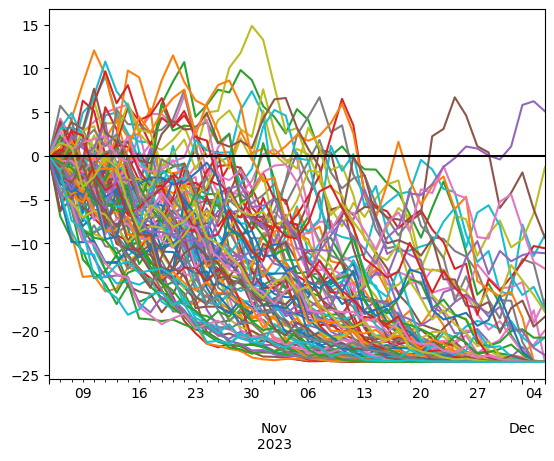

In [162]:
print(option_price_df.iloc[0])
pnl_df = option_price_df.sub(option_price_df.iloc[0], axis=1)
pnl_df.plot(legend = LEGEND_STATE)
plt.axhline(0, color='black')